Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.7}
Error cuadrático medio (MSE) después de ajustar hiperparámetros: 0.08345435165925214
Raíz del error cuadrático medio (RMSE) después de ajustar hiperparámetros: 0.2888846684392443
RMSE en la escala original: 73965.86181617096
MAPE: 22.450402818638366%
RMSE medio en validación cruzada: 0.33495988935579946


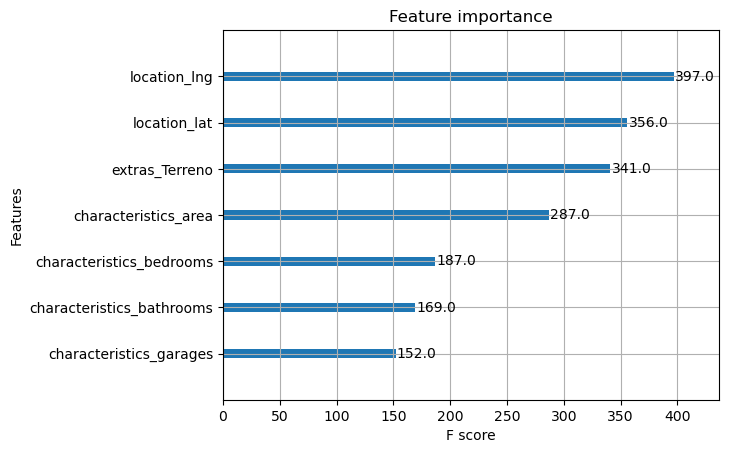

El precio original predicho para la casa es: $246228.86


In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv('./ready_to_go2.csv')

# Aplicar la transformación logarítmica al precio
df['log_price'] = np.log(df['price'])

# Seleccionar las columnas para el modelo, excluyendo 'price_per_m2' para evitar fuga de datos
features = ['characteristics_bedrooms', 'characteristics_bathrooms', 'characteristics_garages',
            'characteristics_area', 'location_lat', 'location_lng', 'extras_Terreno']

# Definir X (características) e y (precio logarítmico)
X = df[features]
y = df['log_price']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

# Definir el espacio de búsqueda de hiperparámetros
param_grid_alt = {
    'n_estimators': [50, 150, 250],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.15, 0.25],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Utilizar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(xgb_model, param_grid_alt, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Evaluación con el mejor modelo
y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Error cuadrático medio (MSE) después de ajustar hiperparámetros: {mse}')
print(f'Raíz del error cuadrático medio (RMSE) después de ajustar hiperparámetros: {rmse}')

# Convertir las predicciones y los valores reales a la escala original
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Calcular el RMSE en la escala original
mse_original = mean_squared_error(y_test_exp, y_pred_exp)
rmse_original = np.sqrt(mse_original)
print(f'RMSE en la escala original: {rmse_original}')

# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100
print(f'MAPE: {mape}%')

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'RMSE medio en validación cruzada: {cv_rmse_scores.mean()}')

# Análisis de importancia de características
plot_importance(best_xgb_model)
plt.show()

# Predicción para una nueva casa
casa_nueva = pd.DataFrame({
    'characteristics_bedrooms': [3],
    'characteristics_bathrooms': [1],
    'characteristics_garages': [2],
    'characteristics_area': [110],
    'location_lat': [-17.768624602981113],
    'location_lng': [-63.198995590646525],
    'extras_Terreno': [273.0],
})

prediccion_precio = best_xgb_model.predict(casa_nueva)

# Revertir la transformación logarítmica
precio_original = np.exp(prediccion_precio)
print(f'El precio original predicho para la casa es: ${precio_original[0]:.2f}')